<h1 align="center">
  <img src="https://raw.githubusercontent.com/Lbalkenhol/candl/main/docs/logos/candl_wordmark%26symbol_col_RGB.png" width="500" alt="candl" /><br>
 Compressed 'CMB-lite' Likelihoods Using Automatic Differentiation<br>
</h1>

---

This notebook is a companion to Balkenhol 2024 (https://arxiv.org/abs/2412.00826) and shows the construction of a foreground-marginalised CMB-lite likelihood for the SPT-3G 2018 TT/TE/EE data set (https://arxiv.org/abs/2212.05642) available in `candl` (https://arxiv.org/abs/2401.13433), through the `candl_data` repo ([here](https://github.com/Lbalkenhol/candl_data)).
Make sure you download and install it first.
The CMB-lite framework was introduced by Dunkley et al. 2013 (https://arxiv.org/abs/1301.0776).
This notebook also uses CosmoPower emulators (https://arxiv.org/abs/2106.03846, https://arxiv.org/abs/2305.06347, https://arxiv.org/abs/2212.05642).


__Overview:__

The notebook will work through the following parts:
1. Initialise the multi-frequency likelihood(s) to be used, the CosmoPower models, define helper functions. [(go to this step)](#init)
1. Minimise the reference multi-frequency likelihood in $\Lambda\mathrm{CDM}$. [(go to this step)](#mf_min)
1. Perform the reconstruction. Defy the reconstruction likelihood, then minimise it and evaluate its Hessian. [(go to this step)](#recon)
1. Plot the foreground-marginalised CMB-only band powers and their covariance matrix. [(go to this step)](#plot)
1. Define the lite likelihood. [(go to this step)](#lite)
1. Minimise the lite lieklihod in $\Lambda\mathrm{CDM}$ and compare the results to the reference multi-frequency and lite likelihoods. [(go to this step)](#lcdm)

You should be able to run the whole notebook in about 5 minutes on your laptop.

__Requirements:__

Tn addition to standard python libraries you will need the following:
* `candl`: https://github.com/Lbalkenhol/candl
* `candl_data`: https://github.com/Lbalkenhol/candl_data
* `JAX`: https://github.com/jax-ml/jax
* `CosmoPower-JAX`: https://github.com/dpiras/cosmopower-jax
* CosmoPower models trained on high-accuracy CAMB spectra: https://github.com/alessiospuriomancini/cosmopower/tree/main/cosmopower/trained_models/SPT_high_accuracy


In [ ]:
# Render plots in place
%matplotlib widget

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
from copy import deepcopy

# candl
import candl
import candl.interface
import candl.tools
import candl.plots
import candl_data

# JAX
import jax
import jax.flatten_util
import jax.numpy as jnp
import jax.scipy as jsp

# Presentation
import seaborn as sns
import sigfig
candl.plots.set_plot_style()# Set the plot style (font sizes, tick widths, ...)


No such comm: a1ccc22bc83649f887b4af75d1e108d1
No such comm: a1ccc22bc83649f887b4af75d1e108d1
No such comm: a1ccc22bc83649f887b4af75d1e108d1
No such comm: a1ccc22bc83649f887b4af75d1e108d1
No such comm: a1ccc22bc83649f887b4af75d1e108d1
No such comm: a1ccc22bc83649f887b4af75d1e108d1


---

<a id='init'></a>

# Initialise Multi-Frequency Likelihoods and Theory Code

We initialise two version of the SPT-3G 2018 TT/TE/EE multi-frequency likelihood below. The first one is the regular version implemented in `candl`. We will use this as our reference to assess the performance of the lite likelihood. The second one is used to build the reconstruction likelihood and is modified as described in the companion paper. We also define some helpful functions and variables for later on.

In [ ]:
# Reference multi-frequency likelihood
candl_like = candl.Like(candl_data.SPT3G_2018_TTTEEE)

# Reformulated multifrequency likelihood to be used in the reconstruction with the following changes:
# Super-sample lensing: we want to add this to the covariance rather than explore (since it depends on ell-by-ell derivatives)
# Aberration: we want to reconstruct this effect in the CMB-only band powers, as it's in the data too. The correction is ell-by-ell so we won't be able to remove it anyway.
# Calibration: re-cast as relative - absolute two step process
candl_like_for_recon = candl.Like(candl_data.SPT3G_2018_TTTEEE, variant="reconstruction")

Successfully initialised candl likelihood 'SPT-3G 2018 TT/TE/EE (Balkenhol et al. 2023)' (type: <class 'candl.likelihood.Like'>).
Data loaded from '/Users/lennart/Research/candl/candl/data/SPT3G_2018_TTTEEE_v0/'.
Functional likelihood form: gaussian_beam_detcov
--------------------------------------------------------------------------------
It will analyse the following spectra:

TT 90x90     (35 bins, bin centres spanning ell = 774.5 - 2946.3)
TE 90x90     (44 bins, bin centres spanning ell = 325.8 - 2946.0)
EE 90x90     (44 bins, bin centres spanning ell = 325.2 - 2945.8)
TT 90x150    (35 bins, bin centres spanning ell = 774.5 - 2946.7)
TE 90x150    (44 bins, bin centres spanning ell = 325.8 - 2946.2)
EE 90x150    (44 bins, bin centres spanning ell = 325.1 - 2945.9)
TT 90x220    (35 bins, bin centres spanning ell = 774.5 - 2946.4)
TE 90x220    (44 bins, bin centres spanning ell = 325.8 - 2946.1)
EE 90x220    (44 bins, bin centres spanning ell = 325.1 - 2945.9)
TT 150x150   (35 bins, 

In [3]:
# Initialise LCDM theory code, define fiducial parameter point

# Grab differentiable, high-precision CosmoPower models
cp_emulator_filenames = {"TT": "cmb_spt_TT_NN.npz",
                         "TE": "cmb_spt_TE_PCAplusNN.npz",
                         "EE": "cmb_spt_EE_NN.npz"}
pars_to_theory_specs = candl.interface.get_CosmoPowerJAX_pars_to_theory_specs_func(cp_emulator_filenames)

# Define fiducial parameters, cosmology matches Planck 2018 best fit
fid_pars = {'H0': 67.37,
            'ombh2': 0.02233,
            'omch2': 0.1198,
            'logA': 3.043,
            'ns': 0.9652,
            'tau': 0.054}

# Nuisance parameters are set to the central values of their priors
for par_name in candl_like.required_nuisance_parameters:
    for prior in candl_like.priors:
        if par_name in prior.par_names:
            fid_pars[par_name] = prior.central_value[prior.par_names.index(par_name)]

Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceversa), or that you are loading a non-standard model from the cosmopower-organization repo.
Falling back to the dictionary, if case this also fails or does not output the right shape make sure you ran the `convert_tf214.py` script, and that a `.npz` file exists among the trained models, and that you ran `pip install .`. Also make sure that you are asking for the right probe between `custom_log` and `custom_pca`.
Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceversa), or that you are loading a non-standard model from the cosmopower-organization repo.
Falling back to the dictionary, if case this also fails or does not output the right shape make sure you r

In [4]:
# Parameter limits for the SPT-3G 2018 TT/TE/EE data set
par_lims = {
'EE_Poisson_150x150': [0.0, 5.0],
'EE_Poisson_150x220': [0.0, 5.0],
'EE_Poisson_220x220': [0.0, 5.0],
'EE_Poisson_90x150': [0.0, 5.0],
'EE_Poisson_90x220': [0.0, 5.0],
'EE_Poisson_90x90': [0.0, 5.0],
'EE_PolGalDust_Alpha': [-5.0, -1.0],
'EE_PolGalDust_Amp': [0.0, 5.0],
'EE_PolGalDust_Beta': [0.5, 2.5],
'Ecal150': [0.9, 1.1],
'Ecal220': [0.9, 1.1],
'Ecal90': [0.9, 1.1],
'Ecal150_rel': [0.9, 1.1],
'Ecal220_rel': [0.9, 1.1],
'Ecal90_rel': [0.9, 1.1],
'Kappa': [-0.01, 0.01],
'TE_PolGalDust_Alpha': [-5.0, -1.0],
'TE_PolGalDust_Amp': [0.0, 5.0],
'TE_PolGalDust_Beta': [0.5, 2.5],
'TT_CIBClustering_Amp': [0.0, 20.0],
'TT_GalCirrus_Alpha': [-3.0, -2.0],
'TT_GalCirrus_Amp': [0.0, 10.0],
'TT_GalCirrus_Beta': [0.0, 2.0],
'TT_CIBClustering_Beta': [0.0, 5.0],
'TT_Poisson_150x150': [0.0, 200.0],
'TT_Poisson_150x220': [0.0, 200.0],
'TT_Poisson_220x220': [0.0, 200.0],
'TT_Poisson_90x150': [0.0, 200.0],
'TT_Poisson_90x220': [0.0, 200.0],
'TT_Poisson_90x90': [0.0, 200.0],
'TT_kSZ_Amp': [0.0, 20.0],
'TT_tSZ_Amp': [0.0, 20.0],
'TT_tSZ_CIB_Corr_Amp': [-1.0, 1.0],
'Tcal150': [0.9, 1.1],
'Tcal220': [0.9, 1.1],
'Tcal90': [0.9, 1.1],
'Tcal150_rel': [0.9, 1.1],
'Tcal220_rel': [0.9, 1.1],
'Tcal90_rel': [0.9, 1.1],
'Tcal150_abs': [0.9, 1.1],
'Ecal150_abs': [0.9, 1.1],
'H0': [50.0, 100.0],
'logA': [1.0, 5.0],
'ns': [0.2, 2.0],
'ombh2': [0.0, 0.1],
'omch2': [0.0, 0.99],
'tau': [0.0, 0.1],
}

In [5]:
# Helpers of various kinds

# Functions for moving between the two calibration formulations
def old_cal_to_new_cal(old_cal):
    new_cal = {"Tcal90_rel": old_cal["Tcal90"]/old_cal["Tcal150"],
                 "Tcal150_rel": 1.0,
                 "Tcal220_rel": old_cal["Tcal220"]/old_cal["Tcal150"],
                 "Tcal150_abs": old_cal["Tcal150"],
                 "Ecal90_rel": old_cal["Ecal90"]/old_cal["Ecal150"],
                 "Ecal150_rel": 1.0,
                 "Ecal220_rel": old_cal["Ecal220"]/old_cal["Ecal150"],
                 "Ecal150_abs": old_cal["Ecal150"],}
    return new_cal

def new_cal_to_old_cal(new_cal):
    old_cal = {"Tcal90": new_cal["Tcal90_rel"]*new_cal["Tcal150_abs"],
               "Tcal150": new_cal["Tcal150_abs"],
               "Tcal220": new_cal["Tcal220_rel"]*new_cal["Tcal150_abs"],
               "Ecal90": new_cal["Ecal90_rel"]*new_cal["Ecal150_abs"],
               "Ecal150": new_cal["Ecal150_abs"],
               "Ecal220": new_cal["Ecal220_rel"]*new_cal["Ecal150_abs"],}
    return old_cal

# Offsets of TT spectra (Some TT spectra of the lieklihood have a different ell_min)
TT_offsets = {"90x90": 0,
              "90x150": 0,
              "90x220": 0,
              "150x150": 0,
              "150x220": 5,
              "220x220": 5}

# Construct the design matrix
ell_bins = {"TT": list(np.arange(750, 2000, 50)) + list(np.arange(2000, 3000, 100)),
            "TE": list(np.arange(300, 2000, 50)) + list(np.arange(2000, 3000, 100)),
            "EE": list(np.arange(300, 2000, 50)) + list(np.arange(2000, 3000, 100))}
ell_bin_centres = {spec: np.array(list(ell_bins[spec][:-1]+np.diff(ell_bins[spec])/2) + [ell_bins[spec][-1]+np.diff(ell_bins[spec])[-1]/2]) for spec in ["TT", "TE", "EE"]}
MV_N_bins = {"TT": 35, "TE": 44, "EE": 44}

spec_types = ["TT", "TE", "EE"]
bands = ["90", "150", "220"]
spec_offsets = {"TT": 0, "TE": MV_N_bins["TT"], "EE": MV_N_bins["TT"]+MV_N_bins["TE"]}
MV_start_ix = {"TT": 0, "TE": MV_N_bins["TT"], "EE": MV_N_bins["TT"]+MV_N_bins["TE"]}
MV_stop_ix = {"TT": MV_N_bins["TT"], "TE": MV_N_bins["TT"]+MV_N_bins["TE"], "EE": MV_N_bins["TT"]+MV_N_bins["TE"]+MV_N_bins["EE"]}
N_CMB_bdp = MV_N_bins["TT"]+MV_N_bins["TE"]+MV_N_bins["EE"]
design_matrix = np.zeros((candl_like.N_bins_total, N_CMB_bdp))

# Loop over spectrum types
for spec in spec_types:
    # Loop over all MV bins
    for b in range(len(ell_bins[spec])):
        # Loop over all multi-frequency spectra
        for i, spec_id in enumerate(candl_like.spec_order):
            # Only contribute if the spectrum type is correct
            if candl_like.spec_types[i] == spec:
                # Loop over all bins in this spectrum
                for mf_bin_ix in range(candl_like.N_bins[i]):
                    # Only contribute if the bin is correct
                    if spec == "TT":
                        if mf_bin_ix == b:
                            design_matrix[candl_like.bins_start_ix[i]+mf_bin_ix, spec_offsets[spec]+b+TT_offsets[spec_id[3:]]] = 1
                    else:
                        if mf_bin_ix == b:
                            design_matrix[candl_like.bins_start_ix[i]+mf_bin_ix, spec_offsets[spec]+b] = 1

# Define window functions of reconstructed band powers

# Initialise a big design matrix (ell-by-ell)
big_design_spec_offsets = {"TT": 0, "TE": candl_like.N_ell_bins_theory, "EE": 2*candl_like.N_ell_bins_theory}
big_design_matrix = np.zeros((18*candl_like.N_ell_bins_theory, 3*candl_like.N_ell_bins_theory))

# Loop over spectrum types
for spec in spec_types:
    # Loop over all MV bins
    for b in range(candl_like.N_ell_bins_theory):
        # Loop over all multi-frequency spectra
        for i, spec_id in enumerate(candl_like.spec_order):
            # Only contribute if the spectrum type is correct
            if candl_like.spec_types[i] == spec:
                # Loop over all bins in this spectrum
                for mf_bin_ix in range(candl_like.N_ell_bins_theory):
                    # Only contribute if the bin is correct
                    if mf_bin_ix == b:
                        big_design_matrix[i*candl_like.N_ell_bins_theory+mf_bin_ix, big_design_spec_offsets[spec]+b] = 1

stacked_window_functions = np.zeros((18*len(candl_like.ells), candl_like.N_bins_total))
for i, spec in enumerate(candl_like.spec_order):
    stacked_window_functions[i*candl_like.N_ell_bins_theory:(i+1)*candl_like.N_ell_bins_theory,candl_like.bins_start_ix[i]:candl_like.bins_stop_ix[i]] = candl_like.window_functions[i]

# Make the window functions
weighting_fac = design_matrix.T @ np.linalg.inv(candl_like.covariance) @ design_matrix
CMB_lite_windows = np.linalg.inv(weighting_fac) @ design_matrix.T @ np.linalg.inv(candl_like.covariance) @ stacked_window_functions.T @ big_design_matrix
for i, spec1 in enumerate(["TT", "TE", "EE"]):
    for j, spec2 in enumerate(["TT", "TE", "EE"]):
        if i != j:
            CMB_lite_windows[MV_start_ix[spec1]:MV_stop_ix[spec1],j*candl_like.N_ell_bins_theory:(j+1)*candl_like.N_ell_bins_theory] = 0.0
CMB_lite_effective_ells = CMB_lite_windows @ np.tile(candl_like.ells, (3, 1)).flatten()

# Calculate the correlation matrix for a given covariance matrix
def cov_2_corr(H):
    S = jnp.diag(1/jnp.sqrt(jnp.abs(jnp.diag(H))))
    return S @ H @ S

---

<a id='min_mf'></a>

# Minimise the Reference Multifrequency Likelihood

We begin by finding the $\Lambda\mathrm{CDM}$ best-fit point of the reference multi-frequency likelihood. Though this step is not necessary for the reconstruction, it allows us to obtain the minimum-variance combination of foreground-subtracted band powers, i.e. the \emph{coadd}, which we will use as a starting point for the reconstruction process. We also use the best-fit point obtained below to assess the performance of the lite likelihood.

In [6]:
# Bundle the candl likelihood and CosmoPower models into a function taking an array input.

# This is a JAX routine that creates a more straightforward interface - from a vector to the dictionary we need
# The function that pops out can be used to undo the transformation
mf_initial_param_vec, mf_param_unravel = jax.flatten_util.ravel_pytree(fid_pars)
mf_param_index = mf_param_unravel(np.arange(len(mf_initial_param_vec)))

# Check the order of parameters
par_order = len(fid_pars)*[0]
for par in list(mf_param_index.keys()):
    par_order[mf_param_index[par]] = par

# Define a likelihood that accepts a vector of parameters as input according to this transformation
mf_like = jax.jit(candl.tools.get_params_to_logl_func(candl_like, pars_to_theory_specs))
@jax.jit
def mf_like_vec(param_vec):
    return mf_like(mf_param_unravel(param_vec))
mf_like_vec_hessian = jax.jit(jax.hessian(mf_like_vec))

In [7]:
# Minimise the multifrequency likelihood using scipy.
# Here we use the truncated Newton method. It uses gradient-information and respects parameter boundaries.
mf_func = jax.jit(lambda p: -mf_like_vec(p))
jac = jax.jit(jax.jacrev(mf_func))
all_mf_par_steps = [mf_initial_param_vec]

res = scipy.optimize.minimize(mf_func,
                              mf_initial_param_vec,
                              method = "TNC",
                              jac = jac,
                              bounds=[(par_lims[p][0], par_lims[p][1]) for p in par_order],
                              callback=lambda p: all_mf_par_steps.append(p),
                              options={"disp": True,
                                       "maxfun": 1000,
                                       "ftol": 1e-8})

# Juggle results into helpful variables
all_mf_par_steps = np.asarray(all_mf_par_steps)
all_mf_logls = jax.vmap(mf_func)(all_mf_par_steps)
mf_bf_ix = np.argmin(all_mf_logls)
all_mf_eval_points = [{p: all_mf_par_steps[ix,i] for i, p in enumerate(par_order)} for ix in range(np.shape(all_mf_par_steps)[0])]

mf_min_results_dict = {"best fit": all_mf_eval_points[mf_bf_ix],# Dictionary of best-fit parameter values
                       "best fit ix": mf_bf_ix,# Index of the minimiser step producing the best fit
                       "logl": np.asarray(all_mf_logls),# Likelihood values
                       "eval points": all_mf_eval_points,# List of parameter dictionaries for all minimiser steps in order
                       "success": res.success,}# Flag indicating the outcome of the minimiser

  NIT   NF   F                       GTG
    0    1  1.032375076034675E+03   1.44077178E+09
tnc: fscale = 0.000103208
    1    8  9.668283152398465E+02   2.38658249E+07
    2   11  9.571528909745862E+02   5.52033732E+07
    3   16  9.487124984518434E+02   1.20096028E+07
    4   23  9.419893875709446E+02   4.53639510E+05
tnc: fscale = 0.00347625
    5   31  9.416583974447855E+02   1.56868012E+05
    6   34  9.413407555506478E+02   5.26939628E+05
    7   37  9.411203840768757E+02   3.68797662E+05
    8   52  9.401639118961455E+02   1.34273715E+05
    9   55  9.400522133397792E+02   9.08544134E+04
   10   71  9.397649544073546E+02   7.09498570E+04
   11   74  9.397449630006881E+02   2.50154215E+04
   12   88  9.397091868337054E+02   8.19890127E+02
tnc: fscale = 0.0848964
   13   96  9.397081181744388E+02   1.60956880E+03
   14   99  9.397080439117250E+02   1.71665741E+03
   15  102  9.397076477354648E+02   1.77873027E+03
   16  110  9.397068792831532E+02   1.97780934E+03
   17  126  9.397

In [8]:
# Grab foreground-subtracted minimum-variance band powers, i.e. the coadd
bf_CMB_only_vec = candl.tools.undo_transformations(candl_like, mf_min_results_dict["best fit"], pars_to_theory_specs)
MV_dict = candl.tools.make_MV_combination(candl_like,
                                          bf_CMB_only_vec,
                                          design_matrix)

---

<a id='recon'></a>

# Define then Minimise Reconstruction Likelihood

Below we perform the reconstruction process in the two-step procedure proposed in the paper:

1. Minimise the reconstruction likelihood.
1. Evaluate the Hessian at the best-fit point.

Gradient information is crucial to quickly minimise the reconstruction likelihood. The Hessian connects to the Fisher matrix and allows us to obtain a sampling noise-free estimate of the covariance matrix.

In [9]:
# The reconstruction likelihood accepts a vector as an input containing first the CMB bins, then the nuisance parameters
nuisance_par_order = list(np.unique(candl_like_for_recon.required_nuisance_parameters + candl_like_for_recon.required_prior_parameters))
recon_fiducial_vec = np.zeros(N_CMB_bdp + len(nuisance_par_order))

@jax.jit
def recon_like(par_vec):

    # Grab CMB band powers
    CMB_contribution = design_matrix @ par_vec[:N_CMB_bdp]

    # Grab additive foregrounds
    nuisance_par_dict = {nuisance_par_order[i]: par_vec[N_CMB_bdp+i] for i in range(len(nuisance_par_order))}
    foreground_contribution = candl.tools.get_foreground_contributions(candl_like_for_recon,
                                                                       nuisance_par_dict,
                                                                       return_type="arr",
                                                                       binning="binned")
    foreground_contribution = jnp.sum(foreground_contribution[0], axis=0)

    # Calibration
    rel_cal = jnp.repeat(candl_like_for_recon.data_model[-2].get_cal_vec(nuisance_par_dict), jnp.array(candl_like_for_recon.N_bins), total_repeat_length=candl_like_for_recon.N_bins_total)# relative (internal) calibration

    # Formulate model
    model_bdp = (CMB_contribution + foreground_contribution)/rel_cal

    # Calculate likelihood
    logl = candl_like_for_recon.logl_function(candl_like_for_recon.data_bandpowers, model_bdp)
    
    # Calculate prior
    nuisance_par_dict_for_prior = {**deepcopy(nuisance_par_dict), **new_cal_to_old_cal(nuisance_par_dict)}
    prior_logl = candl_like_for_recon.prior_logl(nuisance_par_dict_for_prior)

    return - (logl + prior_logl)

recon_like_deriv = jax.jit(jax.jacrev(recon_like))
recon_like_hessian = jax.jit(jax.hessian(recon_like))

In [10]:
# Minimise the reconstruction likelihood using scipy, again using the truncated Newton method.

# Starting point
for spec in spec_types:
    recon_fiducial_vec[MV_start_ix[spec]:MV_stop_ix[spec]] = MV_dict["MV spec"][MV_start_ix[spec]:MV_stop_ix[spec]]
for i, p in enumerate(nuisance_par_order):
    recon_fiducial_vec[N_CMB_bdp+i] = {**mf_min_results_dict["best fit"], **old_cal_to_new_cal(mf_min_results_dict["best fit"])}[p]

# Parameter boundaries (imposing very broad limits for the CMB power)
bounds = [(-10*abs(recon_fiducial_vec[i]), 10*abs(recon_fiducial_vec[i])) for i in range(N_CMB_bdp)]+[(par_lims[p][0], par_lims[p][1]) for p in nuisance_par_order]
bounds[N_CMB_bdp+nuisance_par_order.index("Tcal150_rel")] = (1.0, 1.0)
bounds[N_CMB_bdp+nuisance_par_order.index("Ecal150_rel")] = (1.0, 1.0)

# Minimise
recon_func = jax.jit(lambda p: -recon_like(p))
jac = jax.jit(jax.jacrev(recon_func))
all_par_steps = [recon_fiducial_vec]
res = scipy.optimize.minimize(recon_func,
                              recon_fiducial_vec,
                              method = "TNC",
                              jac = jac,
                              bounds=bounds,
                              callback=lambda p: all_par_steps.append(p),
                              options={"disp": True,
                                       "maxfun": 1000,
                                       "ftol": 1e-8})

# Juggle results into a different format
all_par_steps = np.asarray(all_par_steps)
all_logls = jax.vmap(recon_func)(all_par_steps)
bf_ix = np.argmin(all_logls)

recon_min_results_dict = {"best fit": all_par_steps[bf_ix],
                          "best fit ix": bf_ix,
                          "logl": np.asarray(all_logls),
                          "eval points": all_par_steps,
                          "success": res.success,}

# Grab the covariance of the CMB-only band powers
final_hess = -recon_like_hessian(all_par_steps[bf_ix])
full_cov = np.linalg.inv(final_hess)
spec_cov = full_cov[:N_CMB_bdp, :N_CMB_bdp]

  NIT   NF   F                       GTG
    0    1  8.740480313314829E+02   1.12166885E+05
tnc: fscale = 0.000855298
    1    4  8.728163675120886E+02   3.65509998E+04
    2    8  8.725520107847709E+02   2.51900446E+04
    3   15  8.722072175779974E+02   1.34549750E+03
    4   35  8.715288216531737E+02   4.57276678E+03
    5   39  8.714498273999471E+02   2.36525499E+03
    6   45  8.713644961973694E+02   1.88840870E+02
tnc: fscale = 0.0273712
    7   49  8.713622225814605E+02   1.90654842E+02
    8   63  8.713547293397971E+02   1.92741768E+01
    9   71  8.713533844176122E+02   1.09630782E+01
   10   90  8.713484587921423E+02   4.04460568E+00
   11   98  8.713476256751485E+02   2.55974645E+00
   12  108  8.713472470158500E+02   1.50660114E-01
   13  121  8.713471050906436E+02   4.24954029E-02
tnc: fscale = 1.06058
   14  143  8.713470711439356E+02   6.92513337E-02
   15  148  8.713470698776547E+02   9.11393813E-02
   16  151  8.713470682071212E+02   3.15612645E-01
   17  165  8.713470

---

<a id='plot_recon'></a>

# Plot The Reconstructed Band Powers and Their Covariance

Visualise the results of the reconstruction process. The plots below show in order:

* The estimated CMB-only band powers
* The correlation matrix of the CMB-only band powers and nuisance parameters
* The evolution of the CMB-only band powers during the minimisation process


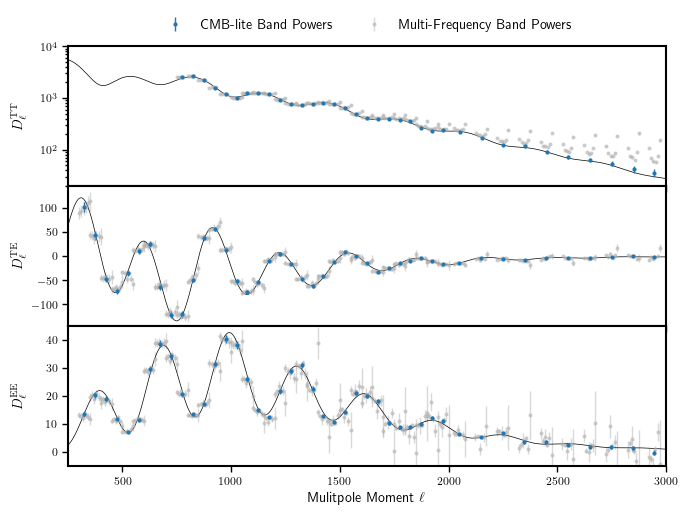

In [11]:
# Plot the foreground-marginalised CMB-only band powers and the original multi-frequency ones

# Grab the best-fit CMB spectrum of the multi-frequency likelihood
theory_dict_unbinned = pars_to_theory_specs(mf_min_results_dict["best fit"], candl_like.ell_max)

# Prepare plot
ylims = {"TT": (2e1, 1e4),
         "TE": (-145, 145),
         "EE": (-5, 45)}

plt.close()

fig, ax = plt.subplots(3,
                       1,
                       sharex=True,
                       sharey=False,
                       figsize=(2*3.464, 1.5*3.464),
                       gridspec_kw={"hspace": 0})

# Plot multi-frequency bandpowers
spec_panel = {"TT": 0, "TE": 1, "EE": 2}
freq_offset = {"90x90": -2.5,
               "90x150": -1.5,
               "90x220": -0.5,
               "150x150": 0.5,
               "150x220": 1.5,
               "220x220": 2.5}
for i, spec in enumerate(candl_like.spec_order):
    lbl = "Multi-Frequency Band Powers"
    if i != 0:
        lbl = None
    ax[spec_panel[spec[:2]]].errorbar(candl_like.effective_ells[candl_like.bins_start_ix[i]:candl_like.bins_stop_ix[i]]+freq_offset[spec[3:]]*10,
                   candl_like.data_bandpowers[candl_like.bins_start_ix[i]:candl_like.bins_stop_ix[i]],
                   np.sqrt(np.diag(candl_like.covariance))[candl_like.bins_start_ix[i]:candl_like.bins_stop_ix[i]],
                   marker="o",
                   lw=0,
                   ms=2,
                   color="0.7",
                   alpha=0.5,
                   label=lbl,
                   elinewidth=1)

for i, spec in enumerate(["TT", "TE", "EE"]):
    lbl = "CMB-lite Band Powers"
    if i != 0:
        lbl = None
    
    # Best-fit of multi-frequency likelihood
    ax[i].plot(theory_dict_unbinned["ell"],
               theory_dict_unbinned[spec],
               color="k",
               lw=0.5)
    
    # Plot CMB-only band powers
    ax[i].errorbar(CMB_lite_effective_ells[MV_start_ix[spec]:MV_stop_ix[spec]],
                   recon_min_results_dict["best fit"][:N_CMB_bdp][MV_start_ix[spec]:MV_stop_ix[spec]],
                   np.sqrt(np.diag(spec_cov)[MV_start_ix[spec]:MV_stop_ix[spec]]),
                   marker="o",
                   ms=2,
                   label=lbl,
                   lw=0,
                   elinewidth=1)
    
    # Makes axes pretty
    ax[i].set_ylim(ylims[spec])
    ax[i].set_ylabel("$D_\ell^{\mathrm{ "+ spec + "}}$")
    ax[i].yaxis.set_label_coords(-0.07, 0.5)

    if spec == "TT":
        ax[i].set_yscale("log")

# Finalise plot
ax[0].legend(ncol=2, loc="center", bbox_to_anchor=((0.0, 0.9, 1.0, 0.5)), reverse=True)
ax[-1].set_xlim((250, 3000))
ax[-1].set_xlabel("Mulitpole Moment $\ell$")

plt.tight_layout()

plt.show()


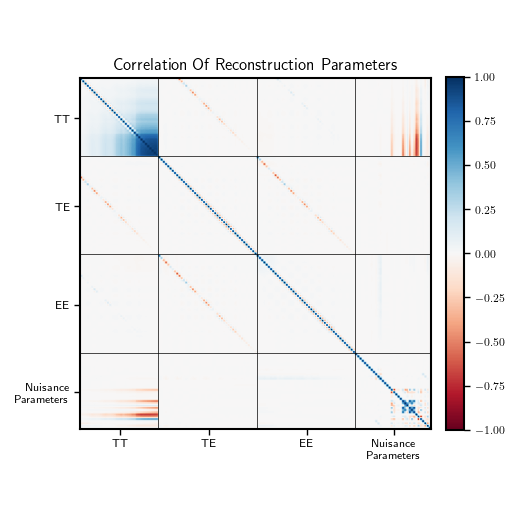

In [12]:
# Show correlation matrix

plt.close()

fig = plt.gcf()
fig.set_size_inches(1.5*3.464, 1.5*3.464)

# Cast covariance to correlation and remove redundant 150GHz relative calibration parameters
arr_to_plot = cov_2_corr(full_cov)
ix_to_delete = [N_CMB_bdp+nuisance_par_order.index("Tcal150_rel"), N_CMB_bdp+nuisance_par_order.index("Ecal150_rel")]
arr_to_plot = np.delete(arr_to_plot, ix_to_delete, axis=0)
arr_to_plot = np.delete(arr_to_plot, ix_to_delete, axis=1)

# Plot
plt.imshow(arr_to_plot,
           vmin=-1,
           vmax=1,
           cmap="RdBu")

# Adjust ticks, add title, finalise plot
xticks = []
for i, spec in enumerate(spec_types):
    plt.axvline(MV_stop_ix[spec]-0.5, color="k", lw=0.5)
    plt.axhline(MV_stop_ix[spec]-0.5, color="k", lw=0.5)
    xticks.append(MV_start_ix[spec] + (MV_stop_ix[spec]-MV_start_ix[spec])/2)
xticks.append(MV_stop_ix["EE"]+(len(nuisance_par_order)-2)/2)
plt.xticks(xticks, spec_types + ["Nuisance\n Parameters"])
plt.yticks(xticks, spec_types + ["Nuisance\nParameters"])

plt.title("Correlation Of Reconstruction Parameters")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()

plt.show()


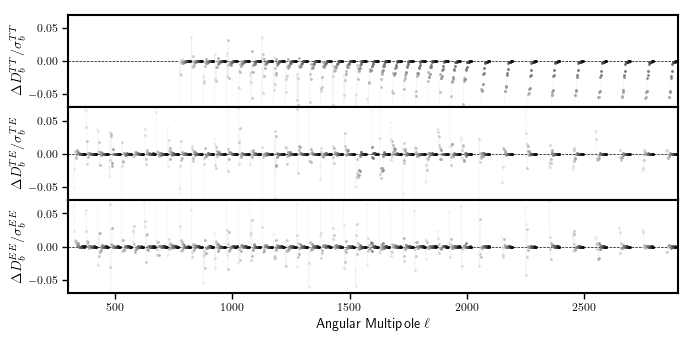

In [13]:
# Show evolution of the CMB-only band powers estimate
# Each cluster of points shows the evolution of one bin, from light to dark
# Note that the overall change from the starting point is small (y axis units)

# Prepare plot
plt.close()

N_min_steps = len(recon_min_results_dict["eval points"])
cols = sns.color_palette("binary", N_min_steps-1)

fig, ax = plt.subplots(3,
                       1,
                       sharex=True,
                       sharey=True,
                       figsize=(2*3.464, 3.464),
                       gridspec_kw={"hspace": 0})

# Loop over spectra
for ix, spec in enumerate(spec_types):
    ax[ix].axhline(0, color="k", lw="0.5", ls="--")

    # Show minimiser steps
    point_spread = 50
    for i in range(N_min_steps-1):
        diff = recon_min_results_dict["eval points"][i][:N_CMB_bdp]- recon_min_results_dict["best fit"][:N_CMB_bdp]
        diff = diff[MV_start_ix[spec]:MV_stop_ix[spec]]
        scale = np.sqrt(np.diag(spec_cov)[MV_start_ix[spec]:MV_stop_ix[spec]])
        full_offset = 0.5*point_spread/N_min_steps
        ax[ix].plot(ell_bin_centres[spec]-full_offset+i*(point_spread/N_min_steps), diff/scale, color=cols[i], lw=0, ms=1, marker="o")
    
    # Add line connecting clusters of points
    for i in range(MV_N_bins[spec]):
        diff = np.asarray([point[:N_CMB_bdp] - recon_min_results_dict["best fit"][:N_CMB_bdp] for point in recon_min_results_dict["eval points"]])
        diff = diff[:,MV_start_ix[spec]+i]
        scale = np.sqrt(np.diag(spec_cov)[MV_start_ix[spec]+i])
        ax[ix].plot(ell_bin_centres[spec][i]-full_offset+(np.arange(N_min_steps)*point_spread/N_min_steps),
                    diff/scale, color="0.5", lw=0.5, alpha=0.1)
    
    # Y axis labels
    ax[ix].set_ylabel(f"$\Delta D^{{{spec}}}_b/\sigma^{{{spec}}}_b$")
    ax[ix].yaxis.set_label_coords(-0.07, 0.5)

# Finalise plot
ax[-1].set_ylim((-0.07, 0.07))
ax[-1].set_xlim((np.amin(ell_bins["EE"]), np.amax(ell_bins["EE"])))
ax[-1].set_xlabel("Angular Multipole $\ell$")

plt.tight_layout()

plt.show()


---

<a id='lite'></a>

# Define the Lite Likelihood

Below we take the products and formulate the lite likelihood used for cosmological analysis. We can optionally save the likelihood in the candl format.
Since we reconstructed the CMB band powers including the aberration signal and an absolute calibration, the corresponding terms appear in the lite likelihood.

In [14]:
# Define the lite likelihood

# Grab different quantities and helpers
CMB_lite_spec_for_like = deepcopy(recon_min_results_dict["best fit"][:N_CMB_bdp])
cmb_lite_chol_for_like = deepcopy(jnp.linalg.cholesky(spec_cov))
cal_prior_cov_to_use = jnp.linalg.inv(jnp.linalg.inv(candl_like_for_recon.priors[-1].prior_covariance)[:2,:2])
lite_ells = deepcopy(candl_like.ells)
lite_long_ells = deepcopy(candl_like.long_ells[:3*len(candl_like.ells)])

# Likelihood function
@jax.jit
def cmb_lite_logl_dict(params):

    # Grab CMB
    cmb_spec = jnp.block([params["Dl"][st] for st in ["TT", "TE", "EE"]])

    # Aberration
    Cl_deriv = jnp.concatenate([
        jnp.gradient(
            cmb_spec[i * len(lite_ells) : (i + 1) * len(lite_ells)]
            * 2
            * jnp.pi
            / (lite_ells * (lite_ells + 1))
        )
        for i in range(3)
        ])  # convert to Cls and calculate derivative
    ab_correction = (
        Cl_deriv * lite_long_ells * (lite_long_ells + 1) / (2 * jnp.pi)
    )  # move to Dl space
    ab_correction *= lite_long_ells
    ab_correction *= -candl_like.data_model[1].aberration_coefficient
    cmb_spec += ab_correction

    # Bin
    cmb_binned = CMB_lite_windows @ cmb_spec

    # Absolute calibration
    ext_cal_vec = jnp.repeat(candl_like_for_recon.data_model[-1].get_cal_vec(params)[:3], jnp.array([MV_N_bins[spec] for spec in ["TT", "TE", "EE"]]), total_repeat_length=np.sum([MV_N_bins[spec] for spec in ["TT", "TE", "EE"]]))# absolute (external) calibration

    # Calculate logl
    delta = CMB_lite_spec_for_like - cmb_binned/ext_cal_vec
    chol_fac = jnp.linalg.solve(cmb_lite_chol_for_like, delta)
    chisq = jnp.dot(chol_fac.T, chol_fac)
    logl = chisq / 2

    # Add tau prior (same as multi-frequency likelihood)
    logl += 0.5 * ((params["tau"] - 0.054) / 0.0074) ** 2

    # Add calibration prior
    cal_delta = 1.0 - jnp.array([params["Tcal150_abs"], params["Ecal150_abs"]])
    cal_prior_fac = jnp.linalg.solve(
        jnp.linalg.cholesky(cal_prior_cov_to_use), cal_delta
    )
    cal_prior = jnp.dot(cal_prior_fac.T, cal_prior_fac) / 2
    logl += cal_prior
    
    return -logl

# Hi-jacking old calibration parameter name here, not very elegant, but I won't compare these in the end anyway, so some confusion of indices of nuisance parameters does not enter the final plots
cmb_lite_dict = lambda pars: cmb_lite_logl_dict({"Dl": pars_to_theory_specs(pars, candl_like.ell_max), "tau": pars["tau"], "Tcal150_abs": pars["Tcal150"], "Ecal150_abs": pars["Ecal150"]})
cmb_lite_dict = jax.jit(cmb_lite_dict)

# Define a likelihood that accepts a vector of parameters as input according to this transformation
@jax.jit
def lite_like_vec(param_vec):
    return cmb_lite_dict(mf_param_unravel(param_vec))
lite_like_vec_hessian = jax.jit(jax.hessian(lite_like_vec))


In [15]:
# Optionally save products of the reconstruction in the candl format
save_output=False

if save_output:
    save_dir = "SPT3G_2018_TTTEEE_lite_v0/"

    bdp_to_save = CMB_lite_spec_for_like
    cov_to_save = spec_cov
    windows_to_save = CMB_lite_windows

    np.savetxt(save_dir+"spt3g_2018_ttteee_bdp_lite.txt", bdp_to_save)
    np.savetxt(save_dir+"spt3g_2018_ttteee_cov_lite.txt", cov_to_save)
    np.savetxt(save_dir+"lite_cal_cov.txt", cal_prior_cov_to_use)
    for i, spec in enumerate(spec_types):
        this_window = np.zeros((MV_N_bins[spec]+1, candl_like.N_ell_bins_theory))
        this_window[0,:] = candl_like.ells
        this_window[1:,:] = windows_to_save[MV_start_ix[spec]:MV_stop_ix[spec],i*candl_like.N_ell_bins_theory:(i+1)*candl_like.N_ell_bins_theory]
        np.savetxt(save_dir+f"windows/{spec}_lxl_window_functions.txt", this_window.T)


---

<a id='lcdm'></a>

# Compare $\Lambda\mathrm{CDM}$ Constraints from the Lite and Multifrequency Likelihoods

Below we compare the performance of the lite and reference multi-frequency likelihoods in $\Lambda\mathrm{CDM}$.
We first minimise the lite likelihood in $\Lambda\mathrm{CDM}$ and then evaluate its Hessian and the Hessian of the reference multi-frequency likelihood at their respective best-fit points to obtain the Fisher matrices.
Though this does not reflect the results of a full MCMC analysis, which was performed in the paper, it's a good approximation for these data in $\Lambda\mathrm{CDM}$ and allows us to quickly benchmark the performance of the lite likelihood.

In [16]:
# Minimise the lite likelihood - again using scipy's truncated Newton method
# This runs much faster than the minimisation of the likelihood multi-frequency likelihood

# Define parameter boundaries
lite_like_pars = ["H0", "ombh2", "omch2", "ns", "logA", "tau", "Tcal150", "Ecal150"]
bounds = [(par_lims[p][0], par_lims[p][1]) for p in par_order]
for i, p in enumerate(par_order):
    if not p in lite_like_pars:
        bounds[i] = (mf_initial_param_vec[i], mf_initial_param_vec[i])

# Minimise
lite_func = jax.jit(lambda p: -lite_like_vec(p))
jac = jax.jit(jax.jacrev(lite_func))
all_par_steps = [mf_initial_param_vec]
res = scipy.optimize.minimize(lite_func,
                              mf_initial_param_vec,
                              method = "TNC",
                              jac = jac,
                              bounds=bounds,
                              callback=lambda p: all_par_steps.append(p),
                              options={"disp": True,
                                       "maxfun": 1000,
                                       "ftol": 1e-8})

# Juggle results format
all_par_steps = np.asarray(all_par_steps)
all_logls = jax.vmap(lite_func)(all_par_steps)
bf_ix = np.argmin(all_logls)
all_eval_points = [{p: all_par_steps[ix,i] for i, p in enumerate(par_order)} for ix in range(np.shape(all_par_steps)[0])]

lite_min_results_dict = {"best fit": all_eval_points[bf_ix],# Dictionary of best-fit parameter values
                         "best fit ix": bf_ix,# Index of the minimiser step producing the best fit
                         "logl": np.asarray(all_logls),# Likelihood values
                         "eval points": all_eval_points,# List of parameter dictionaries for all minimiser steps in order
                         "success": res.success,}# Flag indicating the outcome of the minimiser


  NIT   NF   F                       GTG
    0    1  7.039694109159994E+01   1.80267850E+07
tnc: fscale = 0.000398111
    1    4  6.931740710917073E+01   3.97159383E+05
    2    7  6.871796962360348E+01   2.48624936E+04
tnc: fscale = 0.0240378
    3   12  6.865377919946705E+01   2.05453518E+03
    4   16  6.855029130263358E+01   8.04153655E+03
    5   21  6.853329563283637E+01   7.75227349E+02
    6   26  6.851922963819671E+01   9.68997248E+03
    7   29  6.851834536313218E+01   3.93346280E+02
    8   33  6.851823406322220E+01   6.80622934E+00
tnc: fscale = 0.487704
    9   38  6.851821134018954E+01   7.88133721E-01
   10   42  6.851820282850314E+01   2.15998248E+00
   11   46  6.851820185755608E+01   3.14228812E+00
   12   51  6.851820119345194E+01   2.51585638E-02
   13   56  6.851820100506971E+01   1.52350827E-02
tnc: fscale = 21.0609
   14   61  6.851820096879304E+01   2.57872453E-03
   15   66  6.851820091051884E+01   2.29595486E-01
tnc: |fn-fn-1] = 7.31909e-09 -> convergence
   1

In [17]:
# Grab Fisher matrices (good approximation for parameter contours in LCDM)
mf_bf_ix = mf_min_results_dict["best fit ix"]
lite_bf_ix = lite_min_results_dict["best fit ix"]

mf_hess_at_bf = -mf_like_vec_hessian(jax.flatten_util.ravel_pytree(mf_min_results_dict["best fit"])[0])
lite_hess_at_bf = -lite_like_vec_hessian(jax.flatten_util.ravel_pytree(lite_min_results_dict["best fit"])[0])

# Crop away any non-constrained pars

# Multi-frequency
mf_ix = np.argwhere(np.diag(mf_hess_at_bf)==0).flatten()
cropped_mf_hess_at_bf = deepcopy(mf_hess_at_bf)
cropped_mf_hess_at_bf = np.delete(cropped_mf_hess_at_bf, mf_ix, axis=0)
cropped_mf_hess_at_bf = np.delete(cropped_mf_hess_at_bf, mf_ix, axis=1)
mf_par_cov = np.linalg.inv(cropped_mf_hess_at_bf)
mf_par_order = [par_order[i] for i in range(len(par_order)) if not i in mf_ix]

# Lite
lite_ix = np.argwhere(np.diag(lite_hess_at_bf)==0).flatten()
cropped_lite_hess_at_bf = deepcopy(lite_hess_at_bf)
cropped_lite_hess_at_bf = np.delete(cropped_lite_hess_at_bf, lite_ix, axis=0)
cropped_lite_hess_at_bf = np.delete(cropped_lite_hess_at_bf, lite_ix, axis=1)
lite_par_cov = np.linalg.inv(cropped_lite_hess_at_bf)
lite_par_order = [par_order[i] for i in range(len(par_order)) if not i in lite_ix]

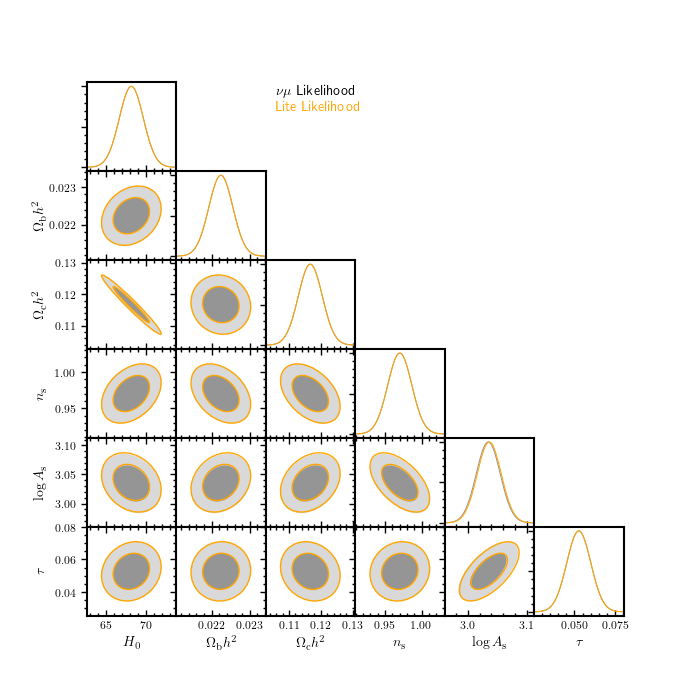

In [18]:
# Plot the constraints

# Prepare plot
pars_to_plot = ["H0", "ombh2", "omch2", "ns", "logA", "tau"]
sigma_plot_range = 3
sigma_levels = 2

plt.close()

# Multi-frequency likelihood
ax = candl.plots.triangle_plot_from_cov(pars_to_plot = pars_to_plot,# which parameters to plot
                                        bf_point = mf_min_results_dict["best fit"],# Newton best-fit point
                                        par_cov = mf_par_cov,# the parameter covariance matrix
                                        pars_in_cov = mf_par_order,# the order of parameters in the covariance
                                        sigma_plot_range = sigma_plot_range,# sets the axes limits
                                        sigma_levels = sigma_levels)# how many sigma levels to plot

# Lite likelihood
ax = candl.plots.triangle_plot_from_cov(pars_to_plot = pars_to_plot,# which parameters to plot
                                        bf_point = lite_min_results_dict["best fit"],# Newton best-fit point
                                        par_cov = lite_par_cov,# the parameter covariance matrix
                                        pars_in_cov = lite_par_order,# the order of parameters in the covariance
                                        sigma_plot_range = sigma_plot_range,# sets the axes limits
                                        sigma_levels = sigma_levels,# how many sigma levels to plot
                                        ax=ax,
                                        contour_colours=["None", "None"],
                                        contour_edgecolour="orange")

# Add a make-shift legend
ax[0,0].text(mf_min_results_dict["best fit"][pars_to_plot[0]]+6*sigma_levels*np.sqrt(mf_par_cov[mf_par_order.index(pars_to_plot[0]),mf_par_order.index(pars_to_plot[0])]),
             0.7,
             "Lite Likelihood",
             color="orange")
ax[0,0].text(mf_min_results_dict["best fit"][pars_to_plot[0]]+6*sigma_levels*np.sqrt(mf_par_cov[mf_par_order.index(pars_to_plot[0]),mf_par_order.index(pars_to_plot[0])]),
             0.9,
             r"$\nu\mu$ Likelihood",
             color="k")

plt.show()

In [19]:
# Quantify the performance of the lite likelihood
for i, p in enumerate(pars_to_plot):
    print("{0: <5} (multifreq)  : {1: <10}".format(p, sigfig.round(float(mf_min_results_dict["best fit"][p]), float(np.sqrt(mf_par_cov[mf_par_order.index(p),mf_par_order.index(p)])), cutoff=99)))
    print("{0: <5} (lite)       : {1: <10}".format(p, sigfig.round(float(lite_min_results_dict["best fit"][p]), float(np.sqrt(lite_par_cov[lite_par_order.index(p),lite_par_order.index(p)])), cutoff=99)))
    print("{0: <5} (∆/σ)        : {1: <10}".format(p, sigfig.round(float((mf_min_results_dict["best fit"][p] - lite_min_results_dict["best fit"][p])/np.sqrt(mf_par_cov[mf_par_order.index(p),mf_par_order.index(p)])), decimals=12)))
    print("{0: <5} (σ_lite/σ_mf): {1: <10}".format(p, sigfig.round(float(np.sqrt(lite_par_cov[lite_par_order.index(p),lite_par_order.index(p)])/np.sqrt(mf_par_cov[mf_par_order.index(p),mf_par_order.index(p)])), decimals=12)))
    print(100*"-")

H0    (multifreq)  : 68.2 ± 1.5
H0    (lite)       : 68.2 ± 1.5
H0    (∆/σ)        : -8.6506509e-05
H0    (σ_lite/σ_mf): 0.998014813621
----------------------------------------------------------------------------------------------------
ombh2 (multifreq)  : 0.02224 ± 0.00031
ombh2 (lite)       : 0.02224 ± 0.00031
ombh2 (∆/σ)        : 0.003812526623
ombh2 (σ_lite/σ_mf): 1.000168726359
----------------------------------------------------------------------------------------------------
omch2 (multifreq)  : 0.1167 ± 0.0038
omch2 (lite)       : 0.1167 ± 0.0038
omch2 (∆/σ)        : -0.000448482027
omch2 (σ_lite/σ_mf): 1.000746061294
----------------------------------------------------------------------------------------------------
ns    (multifreq)  : 0.970 ± 0.016
ns    (lite)       : 0.970 ± 0.016
ns    (∆/σ)        : -0.000850635418
ns    (σ_lite/σ_mf): 0.995803883266
----------------------------------------------------------------------------------------------------
logA  (multifreq)  :